In [1]:
import numpy as np
import pandas as pd
import math

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: numpy._core.multiarray failed to import

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nltk.corpus (from versions: none)
ERROR: No matching distribution found for nltk.corpus


In [2]:
def preprocess_text(text):
    text = str(text)
    # lowercasing
    text = text.lower()
    # Remove Stop Words
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_list = [w for w in word_tokens if not w in stop_words]

    # Remove numbers and special Symbols
    # words like 100m 2m were not removed so using this
    num = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    num_filter = []
    for i in range(0, len(filtered_list)):
        for j in range(0, len(num)):
            if num[j] in filtered_list[i]:
                num_filter.append(filtered_list[i])
                break

    for filter in num_filter:
        filtered_list.remove(filter)

    filtered_list = [w for w in filtered_list if w.isalnum()]
    filtered_list = [w for w in filtered_list if not w.isdigit()]

    # Lematizing
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = [
        wordnet_lemmatizer.lemmatize(w, wordnet.VERB) for w in filtered_list
    ]
    lemmatized_string = " ".join(lemmatized_list)

    return lemmatized_string

In [3]:
import pandas as pd

# Load the BBC News dataset
df = pd.read_csv("../dataset/BBC News Train.csv")

mapping = {"business": 0, "entertainment": 1, "politics": 2, "sport": 3, "tech": 4}
df["CategoryId"] = df["Category"].map(mapping)
df["Text"] = df["Text"].apply(preprocess_text)

# Display the first few rows of the dataset
print(df.head())


   ArticleId                                               Text  Category  \
0       1833  worldcom launch defence lawyers defend former ...  business   
1        154  german business confidence slide german busine...  business   
2       1101  bbc poll indicate economic gloom citizens majo...  business   
3       1976  lifestyle govern mobile choice faster better f...      tech   
4        917  enron boss payout eighteen former enron direct...  business   

   CategoryId  
0           0  
1           0  
2           0  
3           4  
4           0  


In [4]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
features = vectorizer.fit_transform(df["Text"]).toarray()

In [5]:
X = features
y = df.loc[:, "CategoryId"].values
X.shape

(1490, 5000)

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.preprocessing import LabelEncoder
import MySVM
import numpy as np


class OneVsOneSVM:
    """
    Parameters
    ----------
    C : float, optional (default=1.0)
    Penalty parameter C of the error term.

    max_iter : int, optional (default=6000)

    learning_rate : float, optional (default=0.00001)

    Callable Functions
    ------------------

    fit(X,Y) : take data as X, target_labels as Y as input and trains the SVM model

    score(X,Y) : take data as X, target_labels as Y as input and returns the accuracy of the model

    """

    def __init__(self, C=1.0, max_iter=6000, learning_rate=0.00001):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.C = C
        self.svm_classifiers = {}

    def generateClasswiseData(self, X, Y):
        data = {}

        no_of_classes = len(np.unique(Y))
        no_of_samples = X.shape[0]

        for i in range(no_of_classes):
            data[i] = []

        for i in range(no_of_samples):
            data[Y[i]].append(X[i])

        for k in range(no_of_classes):
            data[k] = np.array(data[k])

        return data

    def getPairData(self, d1, d2):

        l1 = d1.shape[0]
        l2 = d2.shape[0]
        data = np.zeros((l1 + l2, d1.shape[1]))
        labels = np.zeros(l1 + l2)

        data[:l1] = d1
        data[l1:] = d2

        labels[:l1] = 1
        labels[l1:] = -1

        return data, labels

    def fit(self, X, Y):
        global le
        le = LabelEncoder()
        le.fit(Y)
        Y = le.transform(Y)

        data = self.generateClasswiseData(X, Y)
        svc = MySVM.SVC(self.C)
        for i in range(len(data)):
            self.svm_classifiers[i] = {}
            for j in range(i + 1, len(np.unique(Y))):
                x, y = self.getPairData(data[i], data[j])
                wts, b, losses = svc.fit(
                    x, y, learning_rate=self.learning_rate, max_itr=self.max_iter
                )
                self.svm_classifiers[i][j] = (wts, b)

    def predict(self, X):
        X = np.array(X)
        classes = len(self.svm_classifiers)
        count = np.zeros(
            classes,
        )
        for i in range(classes):
            for j in range(i + 1, classes):
                W = self.svm_classifiers[i][j][0]
                b = self.svm_classifiers[i][j][1]
                if (np.dot(W, X.T) + b) >= 0:
                    count[i] += 1
                else:
                    count[j] += 1

        index = np.argmax(count)
        return le.inverse_transform([index])


    def score(self, X, Y):
        count = 0
        for i in range(X.shape[0]):
            if Y[i] == self.predict(X[i]):
                count += 1

        return count / X.shape[0]
    
    def predict_proba(self, X):
        X = np.array(X)
        classes = len(self.svm_classifiers)
        votes = np.zeros(classes)

        # Voting from each pairwise classifier
        for i in range(classes):
            for j in range(i + 1, classes):
                W = self.svm_classifiers[i][j][0]
                b = self.svm_classifiers[i][j][1]
                if (np.dot(W, X.T) + b) >= 0:
                    votes[i] += 1
                else:
                    votes[j] += 1

        # Convert votes into probabilities using normalization
        probabilities = votes / np.sum(votes)
        return probabilities

In [8]:
# Initialize and train the OneVsOneSVM model
ovo_SVM = OneVsOneSVM(C=10, max_iter=6000, learning_rate=0.00001)
ovo_SVM.fit(X_train, y_train)

In [9]:
ovo_SVM.score(X_test, y_test)

0.9798657718120806

In [10]:
ovo_SVM.score(X_test, y_test)

0.9798657718120806

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_test = []
y_pred_actual = []

for i in range(len(X_test)):
    y_pred = ovo_SVM.predict([X_test[i]])  # Predict for a single sample
    y_actual = y_test[i]  # Actual label for that sample

    y_pred_test.append(y_pred[0])
    y_pred_actual.append(y_actual)
    
# Calculate precision
precision = precision_score(y_pred_actual, y_pred_test, average='weighted')

# Calculate recall
recall = recall_score(y_pred_actual, y_pred_test, average='weighted')

# Calculate F1 score
f1 = f1_score(y_test, y_pred_test, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Precision: 0.9799231032452508
Recall: 0.9798657718120806
F1 Score: 0.979838049488504


In [12]:
from sklearn.metrics import classification_report

report = classification_report(y_pred_test, y_pred_actual, 
                               target_names=['Business', 'Entertainment', 'Politics', 'Sports', 'Tech'])
print(report)

               precision    recall  f1-score   support

     Business       0.97      0.98      0.98        63
Entertainment       0.98      0.98      0.98        63
     Politics       0.96      0.98      0.97        52
       Sports       1.00      0.98      0.99        66
         Tech       0.98      0.96      0.97        54

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



Classification Report:


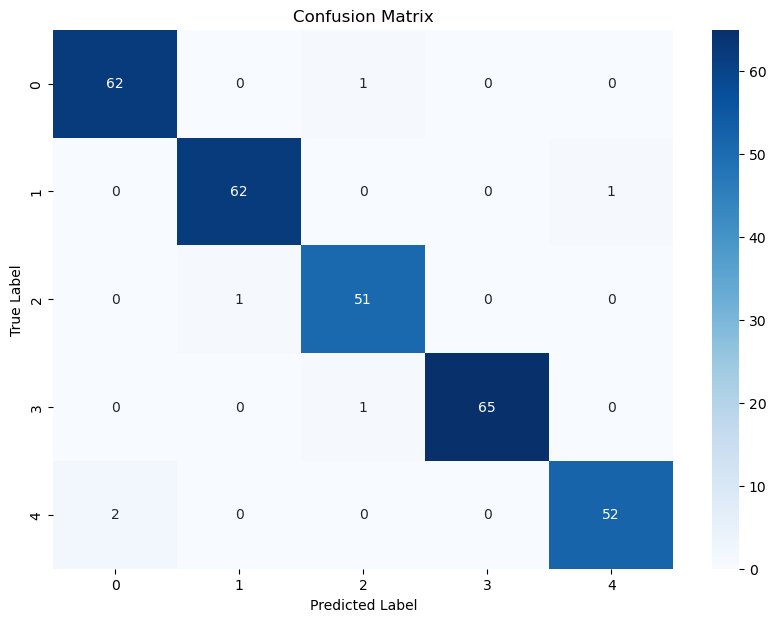

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:")
# Calculate the confusion matrix
cm = confusion_matrix(y_pred_test, y_pred_actual)

# Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Example custom news texts
business_news = "Global market trends indicate a significant rise in e-commerce investments. Major companies are expanding their online presence to capture growing digital consumer demand."
entertainment_news = "The latest blockbuster movie, directed by renowned filmmaker Jane Doe, has shattered box office records and received rave reviews from critics. Red carpet"
politics_news = "In a recent speech, leader michael, down street, council tax, tory leader, election campaign, mr kennedy Leader Government the President outlined new policies and constitutions aimed at improving national healthcare and addressing income inequality in the country."
sports_news = "The local soccer team secured a dramatic victory in the championship final, with a last-minute goal clinching the title against their long-time rivals."
tech_news = "Tech giants Computer are unveiling their newest smart phones featuring advanced AI capabilities and enhanced security features that promise to revolutionize the industry."

# Preprocess and vectorize the news texts
business_vectorized = vectorizer.transform([preprocess_text(business_news)]).toarray()
entertainment_vectorized = vectorizer.transform([preprocess_text(entertainment_news)]).toarray()
politics_vectorized = vectorizer.transform([preprocess_text(politics_news)]).toarray()
sports_vectorized = vectorizer.transform([preprocess_text(sports_news)]).toarray()
tech_vectorized = vectorizer.transform([preprocess_text(tech_news)]).toarray()

mapping = {0: "business", 1: "entertainment", 2: "politics", 3: "sports", 4: "tech"}

# Predict the category
predicted_business = ovo_SVM.predict(business_vectorized)[0]
predicted_entertainment = ovo_SVM.predict(entertainment_vectorized)[0]
predicted_politics = ovo_SVM.predict(politics_vectorized)[0]
predicted_sports = ovo_SVM.predict(sports_vectorized)[0]
predicted_tech = ovo_SVM.predict(tech_vectorized)[0]

predicted_business1 = ovo_SVM.predict_proba(business_vectorized)
predicted_entertainment1 = ovo_SVM.predict_proba(entertainment_vectorized)
predicted_politics1 = ovo_SVM.predict_proba(politics_vectorized)
predicted_sports1 = ovo_SVM.predict_proba(sports_vectorized)
predicted_tech1 = ovo_SVM.predict_proba(tech_vectorized)

# Print the predicted categories
print(f"Business news predicted as: {mapping[predicted_business]}")
print(f"Entertainment news predicted as: {mapping[predicted_entertainment]}")
print(f"Politics news predicted as: {mapping[predicted_politics]}")
print(f"Sports news predicted as: {mapping[predicted_sports]}")
print(f"Tech news predicted as: {mapping[predicted_tech]}")

print(f"Business news predicted as: {predicted_business1}")
print(f"Entertainment news predicted as: {predicted_entertainment1}")
print(f"Politics news predicted as: {predicted_politics1}")
print(f"Sports news predicted as: {predicted_sports1}")
print(f"Tech news predicted as: {predicted_tech1}")



Business news predicted as: business
Entertainment news predicted as: entertainment
Politics news predicted as: politics
Sports news predicted as: sports
Tech news predicted as: tech
Business news predicted as: [[0.84495899 0.00819182 0.00772838 0.00623534 0.13288547]]
Entertainment news predicted as: [[0.01842721 0.91494485 0.01660144 0.01655663 0.03346987]]
Politics news predicted as: [[2.56482351e-03 3.14158143e-04 9.96067999e-01 3.78178131e-04
  6.74841528e-04]]
Sports news predicted as: [[0.03110613 0.01843589 0.02301558 0.91074113 0.01670127]]
Tech news predicted as: [[0.14553324 0.23473351 0.08934445 0.06467527 0.46571354]]


In [15]:
# Evaluate the model
accuracy = ovo_SVM.score(X, y)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 99.26%


In [16]:
import joblib

# Save the model to disk
filename = "../model/svm.pkl"
joblib.dump(ovo_SVM, filename)



['../model/svm.pkl']

In [17]:
# save the vecorizer
filename = "../model/tfidf.pkl"
joblib.dump(vectorizer, filename)

['../model/tfidf.pkl']

# Import the necessary

In [22]:
import joblib

# Load the model from disk
filename = "../model/svm.pkl"
loaded_model = joblib.load(filename)


In [23]:
# Load the vectorizer
filename = "../model/tfidf.pkl"
loaded_vectorizer = joblib.load(filename)

In [24]:
# Example custom news texts
business_news = "Global market trends indicate a significant rise in e-commerce investments. Major companies are expanding their online presence to capture growing digital consumer demand."
entertainment_news = "The latest blockbuster movie, directed by renowned filmmaker Jane Doe, has shattered box office records and received rave reviews from critics. Red carpet"
politics_news = "In a recent speech, leader michael, down street, council tax, tory leader, election campaign, mr kennedy Leader Government the President outlined new policies and constitutions aimed at improving national healthcare and addressing income inequality in the country."
sports_news = "The local soccer team secured a dramatic victory in the championship final, with a last-minute goal clinching the title against their long-time rivals."
tech_news = "Tech giants Computer are unveiling their newest smart phones featuring advanced AI capabilities and enhanced security features that promise to revolutionize the industry."

# Preprocess and vectorize the news texts
business_vectorized = loaded_vectorizer.transform([preprocess_text(business_news)]).toarray()
entertainment_vectorized = loaded_vectorizer.transform([preprocess_text(entertainment_news)]).toarray()
politics_vectorized = loaded_vectorizer.transform([preprocess_text(politics_news)]).toarray()
sports_vectorized = loaded_vectorizer.transform([preprocess_text(sports_news)]).toarray()
tech_vectorized = loaded_vectorizer.transform([preprocess_text(tech_news)]).toarray()

mapping = {0: "business", 1: "entertainment", 2: "politics", 3: "sports", 4: "tech"}

# Predict the category
predicted_business = loaded_model.predict(business_vectorized)[0]
predicted_entertainment = loaded_model.predict(entertainment_vectorized)[0]
predicted_politics = loaded_model.predict(politics_vectorized)[0]
predicted_sports = loaded_model.predict(sports_vectorized)[0]
predicted_tech = loaded_model.predict(tech_vectorized)[0]

predicted_business1 = loaded_model.predict_proba(business_vectorized)
predicted_entertainment1 = loaded_model.predict_proba(entertainment_vectorized)
predicted_politics1 = loaded_model.predict_proba(politics_vectorized)
predicted_sports1 = loaded_model.predict_proba(sports_vectorized)
predicted_tech1 = loaded_model.predict_proba(tech_vectorized)

# Print the predicted categories
print(f"Business news predicted as: {mapping[predicted_business]}")
print(f"Entertainment news predicted as: {mapping[predicted_entertainment]}")
print(f"Politics news predicted as: {mapping[predicted_politics]}")
print(f"Sports news predicted as: {mapping[predicted_sports]}")
print(f"Tech news predicted as: {mapping[predicted_tech]}")

print(f"Business news predicted as: {predicted_business1}")
print(f"Entertainment news predicted as: {predicted_entertainment1}")
print(f"Politics news predicted as: {predicted_politics1}")
print(f"Sports news predicted as: {predicted_sports1}")
print(f"Tech news predicted as: {predicted_tech1}")



Business news predicted as: business
Entertainment news predicted as: entertainment
Politics news predicted as: politics
Sports news predicted as: sports
Tech news predicted as: tech
Business news predicted as: [[0.84495899 0.00819182 0.00772838 0.00623534 0.13288547]]
Entertainment news predicted as: [[0.01842721 0.91494485 0.01660144 0.01655663 0.03346987]]
Politics news predicted as: [[2.56482351e-03 3.14158143e-04 9.96067999e-01 3.78178131e-04
  6.74841528e-04]]
Sports news predicted as: [[0.03110613 0.01843589 0.02301558 0.91074113 0.01670127]]
Tech news predicted as: [[0.14553324 0.23473351 0.08934445 0.06467527 0.46571354]]


In [25]:
# New News
tech_news = "Iranian hackers distributed information about Donald Trump's electoral campaign to people linked to the Biden campaign, according to the FBI and US intelligence agencies. US officials now believe that information taken from the Trump campaign was sent in unsolicited emails to people linked to the campaign in late June and early July - before Biden dropped out of the race for president. There is currently no evidence that the hackers received any reply from any recipients. In August, officials warned that Iran hopes to stoke discord and undermine confidence in US institutions ahead of the November election. US officials said that Iran had used “social engineering and other efforts” to seek out direct access to both the Democratic and Republican campaigns – a tactic they said had been used by both Iran and Russia in other countries around the world."
tech_vectorized = loaded_vectorizer.transform([preprocess_text(tech_news)]).toarray()
predicted_tech = loaded_model.predict(tech_vectorized)[0]
predicted_tech1 = loaded_model.predict_proba(tech_vectorized)
print(f"Tech news predicted as: {mapping[predicted_tech]}")
print(f"Tech news predicted as: {predicted_tech1}")
mapping = {0: "business", 1: "entertainment", 2: "politics", 3: "sports", 4: "tech"}

Tech news predicted as: tech
Tech news predicted as: [[0.28328705 0.04040974 0.03388404 0.02412339 0.61829578]]
